Predicting whether income exceeds $50K/yr based on census data. 

dataset - https://archive.ics.uci.edu/dataset/2/adult

Attributes 

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
income: >50K, <=50K.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [5]:
import os

## Create DataFrames

In [6]:
# define training and testing file paths
train_data_file_path = 'Dataset\\adult.data'
test_data_file_path = 'Dataset\\adult.test'

In [7]:
# define column names
column_names = [
    "Age", 
    "Work_class", 
    "Final_Weight", 
    "Education", 
    "Education_Num", 
    "Marital_Status", 
    "Occupation",
    "Relationship", 
    "Race", 
    "Sex", 
    "Capital_Gain", 
    "Capital_Loss", 
    "Hours_per_Week", 
    "Native_Country",
    "Income"
]

Reference - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [8]:
# read training dataset into DataFrame
try:
    train_data = pd.read_csv(train_data_file_path, delimiter=',', names=column_names, skipinitialspace=True)
except FileNotFoundError:
    print(f"Error: File '{train_data_file_path}' not found.")
    exit()

In [9]:
# preview after adding into DataFrame
train_data.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [10]:
# read testing dataset into DataFrame
# 1st row (header)should remove in adult.test file 
try:
    test_data = pd.read_csv(test_data_file_path, delimiter=',', names=column_names, skipinitialspace=True, skiprows=1)
except FileNotFoundError:
    print(f"Error: File '{test_data_file_path}' not found.")
    exit()

In [11]:
# preview after adding into DataFrame
test_data.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K.
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K.
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K.
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K.


### Merge DataFrames 

Reference -  https://pandas.pydata.org/docs/reference/api/pandas.concat.html
             https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html#

In [12]:
# check data types of Training and Testing DataFrames
print("Training Data")
print(train_data.dtypes)
print("")
print("Testing Data")
print(test_data.dtypes)

Training Data
Age                int64
Work_class        object
Final_Weight       int64
Education         object
Education_Num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_Week     int64
Native_Country    object
Income            object
dtype: object

Testing Data
Age                int64
Work_class        object
Final_Weight       int64
Education         object
Education_Num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_Week     int64
Native_Country    object
Income            object
dtype: object


In [13]:
# check null values of both DataFrames
print("Training Data")
print(train_data.isnull().sum())
print("")
print("Testing Data")
print(test_data.isnull().sum())

Training Data
Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64

Testing Data
Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64


In [14]:
# there are no any null values in both DataFrames
# There is no difference in data types of columns
# so we can combine into a single DataFrame
census_income_df = pd.concat([train_data, test_data])

In [15]:
census_income_df.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [16]:
# Shuffle the merged data for prevents any bias and ensure the data is randomized
census_income_df = census_income_df.sample(frac=1).reset_index(drop=True)

In [17]:
census_income_df.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,34,Private,128063,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,36,United-States,<=50K
1,57,Private,317847,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Male,0,2824,50,United-States,>50K
2,41,Private,58124,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
3,52,Private,150930,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
4,33,Private,248584,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,United-States,<=50K
5,39,Private,113151,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K
6,28,Private,183523,Assoc-acdm,12,Never-married,Adm-clerical,Own-child,White,Male,0,0,35,United-States,<=50K.
7,44,Private,244172,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,Mexico,<=50K.
8,32,Private,73498,7th-8th,4,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,26,Private,366889,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K.


In [18]:
# CSV file saving directory checking
directory = os.path.dirname(train_data_file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

In [19]:
# define file paths to save datasets as CSV
census_income_df_file_path = os.path.join(directory, 'census_income_datset.csv')

In [20]:
# save training and testing DataFrames as CSV
try:
    census_income_df.to_csv(census_income_df_file_path, index=False)
    print(f"Census Income Data CSV file saved successfully at: {census_income_df_file_path}")

except PermissionError:
    print(f"Error: Permission denied to save files in directory: {directory}")

Census Income Data CSV file saved successfully at: Dataset\census_income_datset.csv


## Data Cleaning

In [21]:
census_income_df.shape

(48842, 15)

### 1. Check null values

In [22]:
census_income_df.isnull().sum()

Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64

In [23]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  48842 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Currently there are no any null values

In [24]:
# check unique values
census_income_df.nunique()

Age                  74
Work_class            9
Final_Weight      28523
Education            16
Education_Num        16
Marital_Status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_Gain        123
Capital_Loss         99
Hours_per_Week       96
Native_Country       42
Income                4
dtype: int64

In [25]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 75 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 73 53 71 76 80 70 68 81 74 90 82 83 85 79 77 78 84 88 86
 89 87]


Work_class
['Private' '?' 'Self-emp-not-inc' 'State-gov' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Never-worked' 'Without-pay']


Final_Weight
[128063 317847  58124 ... 310850 446512  32186]


Education
['HS-grad' 'Masters' 'Assoc-voc' 'Some-college' 'Bachelors' 'Assoc-acdm'
 '5th-6th' '7th-8th' '10th' '9th' '11th' 'Prof-school' 'Doctorate' '12th'
 '1st-4th' 'Preschool']


Education_Num
[ 9 14 11 10 13 12  3  4  6  5  7 15 16  8  2  1]


Marital_Status
['Divorced' 'Married-civ-spouse' 'Never-married' 'Married-spouse-absent'
 'Separated' 'Widowed' 'Married-AF-spouse']


Occupation
['Other-service' 'Exec-managerial' 'Craft-repair' 'Sales' 'Adm-clerical'
 'Transport-moving' '?' 'Prof-specialty' 'Machine-op-inspct'
 'Protective-serv' 'Tech-support' 'Handlers-c

There are missing values represented by '?' in Work_class, Occupation and Native_Country columns.
Also have to convert '<=50K.' into '<=50K' and '>50K.' into '>50K' in Income column.

In [26]:
# replace '?' with NaN
#census_income_df.replace(' ?', pd.NA, inplace=True)

census_income_df.replace('?', np.nan, inplace=True) 

In [27]:
# replace values in 'Income' column
census_income_df['Income'] = census_income_df['Income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

In [28]:
# check unique values in each columns after modifications
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 75 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 73 53 71 76 80 70 68 81 74 90 82 83 85 79 77 78 84 88 86
 89 87]


Work_class
['Private' nan 'Self-emp-not-inc' 'State-gov' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Never-worked' 'Without-pay']


Final_Weight
[128063 317847  58124 ... 310850 446512  32186]


Education
['HS-grad' 'Masters' 'Assoc-voc' 'Some-college' 'Bachelors' 'Assoc-acdm'
 '5th-6th' '7th-8th' '10th' '9th' '11th' 'Prof-school' 'Doctorate' '12th'
 '1st-4th' 'Preschool']


Education_Num
[ 9 14 11 10 13 12  3  4  6  5  7 15 16  8  2  1]


Marital_Status
['Divorced' 'Married-civ-spouse' 'Never-married' 'Married-spouse-absent'
 'Separated' 'Widowed' 'Married-AF-spouse']


Occupation
['Other-service' 'Exec-managerial' 'Craft-repair' 'Sales' 'Adm-clerical'
 'Transport-moving' nan 'Prof-specialty' 'Machine-op-inspct'
 'Protective-serv' 'Tech-support' 'Handlers-c

### 2. Handle null values

Reference - https://pandas.pydata.org/docs/user_guide/missing_data.html

In [29]:
#check how many records in the dataset 
census_income_df.shape

(48842, 15)

In [30]:
# number of NaN values in each row
nan_rows_count = census_income_df.isna().sum(axis=1)

# total number of rows with NaN values
total_nan_rows = (nan_rows_count > 0).sum()

print("Total number of rows with NaN values:", total_nan_rows)


Total number of rows with NaN values: 3620


There are so many rows have nan values. So can't drop that rows. Use imputation to handle null values

In [31]:
# Non-Null count
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      46043 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      46033 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Non value amounts in the dataset.
Work_class - 2799 Null values,
Occupation - 2809 Null values,
Native_Country - 857 Null values

In [32]:
census_income_df.head() 

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,34,Private,128063,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,36,United-States,<=50K
1,57,Private,317847,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Male,0,2824,50,United-States,>50K
2,41,Private,58124,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
3,52,Private,150930,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
4,33,Private,248584,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,United-States,<=50K


### Handle Work class column Null values

In [33]:
# classes of Income
print(census_income_df['Income'].unique())

['<=50K' '>50K']


Basically we should consider Income. So fill missing values in the 'Work_class' column based on the Mode for each income class (<=50K or >50K).

Split dataset based on Income. Can split into 2 classes.

In [34]:
income_less_50k = census_income_df[census_income_df['Income'] == '<=50K']
income_greater_50k = census_income_df[census_income_df['Income'] == '>50K']

In [35]:
income_less_50k.head()

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,34,Private,128063,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,36,United-States,<=50K
2,41,Private,58124,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
3,52,Private,150930,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
4,33,Private,248584,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,United-States,<=50K
5,39,Private,113151,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K


In [36]:
income_greater_50k.head()

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
1,57,Private,317847,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Male,0,2824,50,United-States,>50K
17,65,Private,90113,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
18,33,Private,287908,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,50,United-States,>50K
24,35,State-gov,126569,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,40,United-States,>50K
29,27,Private,183523,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,>50K


In [37]:
# Filter the 'Work Class' column based on income

under50K_workClass = income_less_50k['Work_class'].value_counts()
over50K_workClass = income_greater_50k['Work_class'].value_counts()

In [38]:
under50K_workClass

Work_class
Private             26519
Self-emp-not-inc     2785
Local-gov            2209
State-gov            1451
Federal-gov           871
Self-emp-inc          757
Without-pay            19
Never-worked           10
Name: count, dtype: int64

In [39]:
over50K_workClass

Work_class
Private             7387
Self-emp-not-inc    1077
Self-emp-inc         938
Local-gov            927
Federal-gov          561
State-gov            530
Without-pay            2
Name: count, dtype: int64

Plot Work classes according to the Income classes

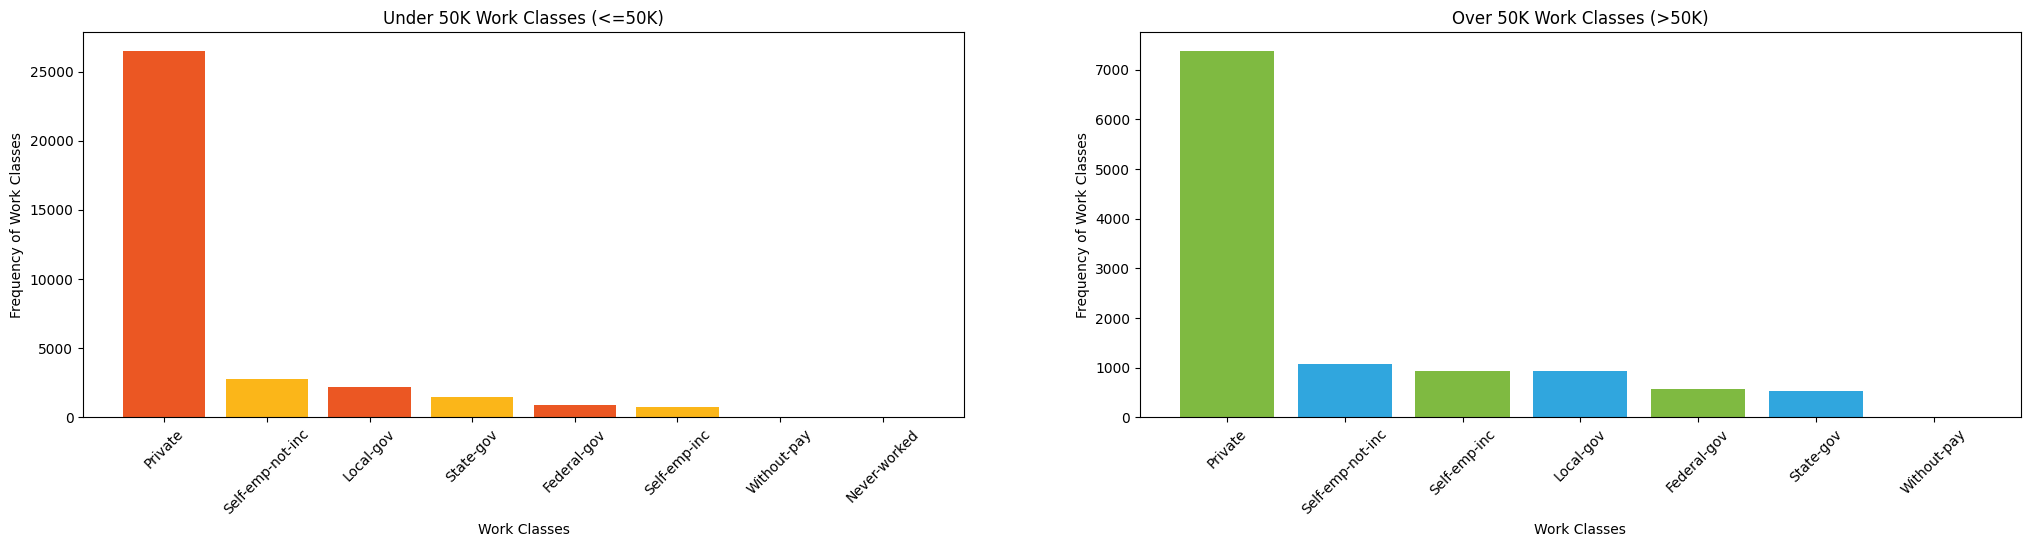

In [40]:
#colors
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (25,5))

ax1.bar(under50K_workClass.index,under50K_workClass.values,color=under50K_color)
ax1.set_xlabel("Work Classes")
ax1.set_ylabel("Frequency of Work Classes")
ax1.set_title("Under 50K Work Classes (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

ax2.bar(over50K_workClass.index,over50K_workClass.values,color=over50K_color)
ax2.set_xlabel("Work Classes")
ax2.set_ylabel("Frequency of Work Classes")
ax2.set_title("Over 50K Work Classes (>50K)")
ax2.tick_params(axis='x', rotation=45) 

In [41]:
# find Work class mode for each income class
mode_less_50k_workclass = income_less_50k['Work_class'].mode()[0]
mode_greater_50k_workclass = income_greater_50k['Work_class'].mode()[0]
print('Mode of Less than 50k income:', mode_less_50k_workclass )
print('Mode of Greater than 50k income:', mode_greater_50k_workclass)

Mode of Less than 50k income: Private
Mode of Greater than 50k income: Private


So the mode of Work classes for the both Income classes is 'Private'.Now we can fill null values of 'Work_class' column with 'Private'.

In [42]:
# Fill missing values based on income class
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Work_class'].isnull()), 'Work_class'] = mode_less_50k_workclass
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Work_class'].isnull()), 'Work_class'] = mode_greater_50k_workclass

Check if 'Work_class' column is ok now.

In [43]:
#check unique values of Work_class column
print(census_income_df['Work_class'].unique())

['Private' 'Self-emp-not-inc' 'State-gov' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Never-worked' 'Without-pay']


In [44]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      46033 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


'Work class' column doesn't have any null values

### Handle Occupation column Null values

In [45]:
# Filter the 'Occupation' column based on income

under50K_occupation = income_less_50k['Occupation'].value_counts()
over50K_occupation = income_greater_50k['Occupation'].value_counts()

In [46]:
under50K_occupation

Occupation
Adm-clerical         4843
Craft-repair         4729
Other-service        4719
Sales                4029
Prof-specialty       3388
Exec-managerial      3178
Machine-op-inspct    2650
Handlers-cleaners    1934
Transport-moving     1874
Farming-fishing      1317
Tech-support         1026
Protective-serv       675
Priv-house-serv       239
Armed-Forces           10
Name: count, dtype: int64

In [47]:
over50K_occupation

Occupation
Exec-managerial      2908
Prof-specialty       2784
Sales                1475
Craft-repair         1383
Adm-clerical          768
Transport-moving      481
Tech-support          420
Machine-op-inspct     372
Protective-serv       308
Other-service         204
Farming-fishing       173
Handlers-cleaners     138
Armed-Forces            5
Priv-house-serv         3
Name: count, dtype: int64

Plot Occupations according to the Income classes

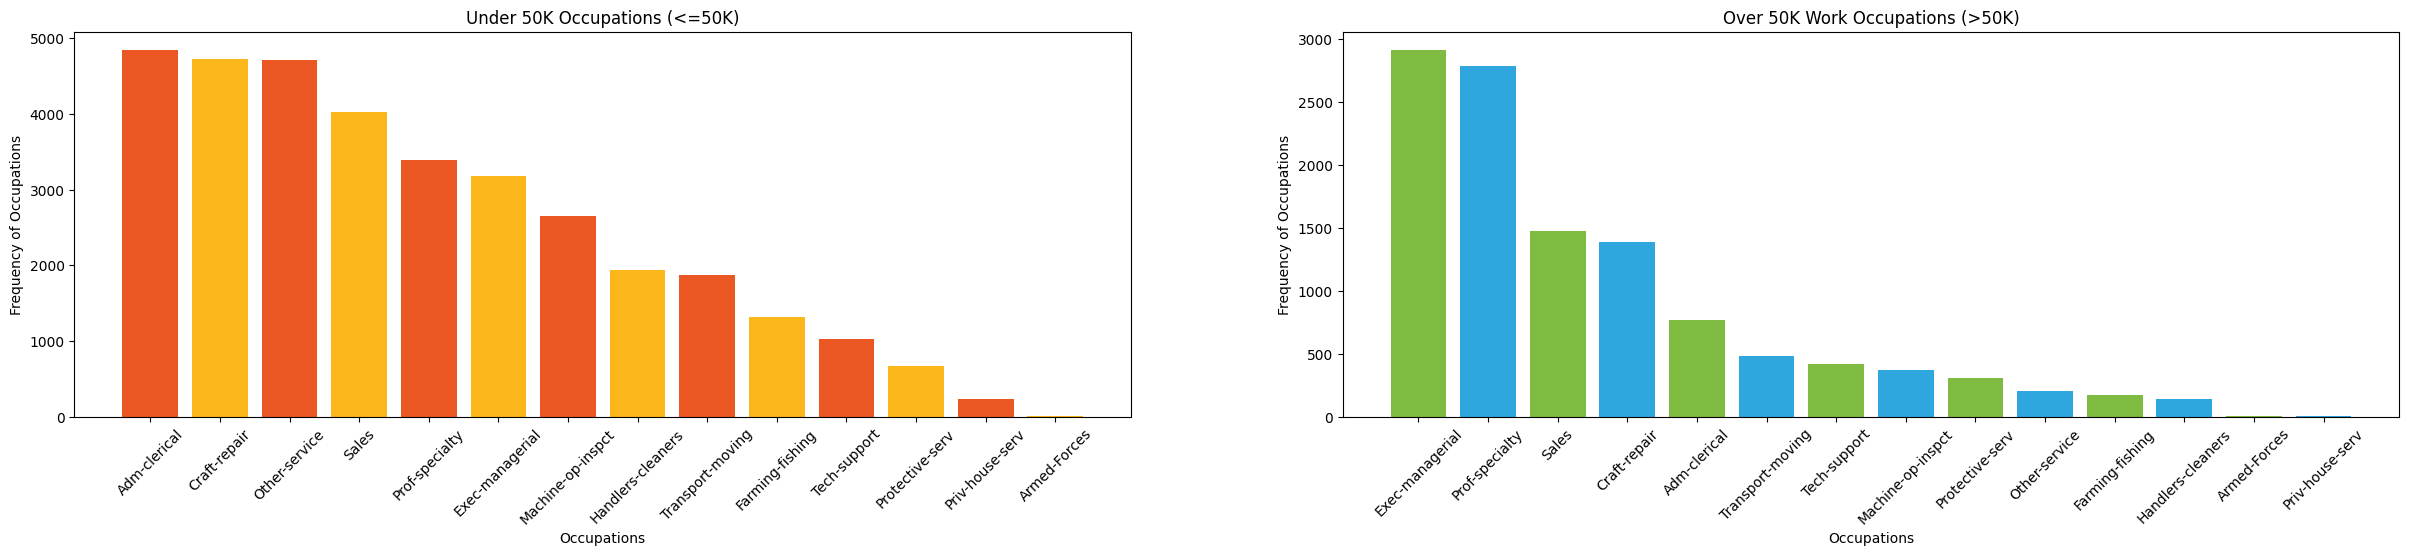

In [48]:
#colors
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,5))

ax1.bar(under50K_occupation.index,under50K_occupation.values,color=under50K_color)
ax1.set_xlabel("Occupations")
ax1.set_ylabel("Frequency of Occupations")
ax1.set_title("Under 50K Occupations (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability


ax2.bar(over50K_occupation.index,over50K_occupation.values,color=over50K_color)
ax2.set_xlabel("Occupations")
ax2.set_ylabel("Frequency of Occupations")
ax2.set_title("Over 50K Work Occupations (>50K)")
ax2.tick_params(axis='x', rotation=45)

In [49]:
# find Occupation mode for each income class
mode_less_50k_occupation = income_less_50k['Occupation'].mode()[0]
mode_greater_50k_occupation = income_greater_50k['Occupation'].mode()[0]
print('Mode of Less than 50k income:', mode_less_50k_occupation)
print('Mode of Greater than 50k income:', mode_greater_50k_occupation)

Mode of Less than 50k income: Adm-clerical
Mode of Greater than 50k income: Exec-managerial


So the mode of Occupations for '<=50K' Income classes is 'Adm-clerical'.And the mode of Occupations for '>50K' Income classes is 'Exec-managerial'.Now we can fill null values of 'Work_class' column.

In [50]:
# Fill missing values based on income class
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Occupation'].isnull()), 'Occupation'] = mode_less_50k_occupation
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Occupation'].isnull()), 'Occupation'] = mode_greater_50k_occupation

Check if 'Occupation' column is ok now.

In [51]:
#check unique values of Work_class column
print(census_income_df['Occupation'].unique())

['Other-service' 'Exec-managerial' 'Craft-repair' 'Sales' 'Adm-clerical'
 'Transport-moving' 'Prof-specialty' 'Machine-op-inspct' 'Protective-serv'
 'Tech-support' 'Handlers-cleaners' 'Farming-fishing' 'Priv-house-serv'
 'Armed-Forces']


In [52]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


'Occupation' column doesn't have any null values

### Handle Native Country column Null values

In [53]:
# Filter the 'Native country' column based on income

under50K_nativeCountry = income_less_50k['Native_Country'].value_counts()
over50K_nativeCountry = income_greater_50k['Native_Country'].value_counts()

In [54]:
under50K_nativeCountry

Native_Country
United-States                 33138
Mexico                          904
Philippines                     210
Puerto-Rico                     164
Germany                         148
El-Salvador                     144
Canada                          119
Cuba                            104
Dominican-Republic               98
South                            95
Jamaica                          91
India                            89
China                            86
Guatemala                        85
Columbia                         81
England                          80
Vietnam                          79
Italy                            71
Poland                           70
Haiti                            66
Japan                            60
Portugal                         55
Nicaragua                        46
Peru                             42
Ecuador                          39
Taiwan                           39
Iran                             37
Greece       

In [55]:
over50K_nativeCountry

Native_Country
United-States                 10694
Philippines                      85
Canada                           63
India                            62
Germany                          58
England                          47
Mexico                           47
China                            36
Cuba                             34
Italy                            34
Japan                            32
Taiwan                           26
Iran                             22
South                            20
Puerto-Rico                      20
Greece                           18
Poland                           17
France                           16
Jamaica                          15
Portugal                         12
El-Salvador                      11
Ireland                          11
Cambodia                          9
Haiti                             9
Yugoslavia                        8
Hong                              8
Vietnam                           7
Ecuador      

Mostly includes United States data.Majority of both income groups are from US.

In [56]:
# Create a cross-tabulation
cross_tab = pd.crosstab(census_income_df['Native_Country'], census_income_df['Income'])

# Display the cross-tabulation
print(cross_tab)

Income                      <=50K   >50K
Native_Country                          
Cambodia                       19      9
Canada                        119     63
China                          86     36
Columbia                       81      4
Cuba                          104     34
Dominican-Republic             98      5
Ecuador                        39      6
El-Salvador                   144     11
England                        80     47
France                         22     16
Germany                       148     58
Greece                         31     18
Guatemala                      85      3
Haiti                          66      9
Holand-Netherlands              1      0
Honduras                       18      2
Hong                           22      8
Hungary                        13      6
India                          89     62
Iran                           37     22
Ireland                        26     11
Italy                          71     34
Jamaica         

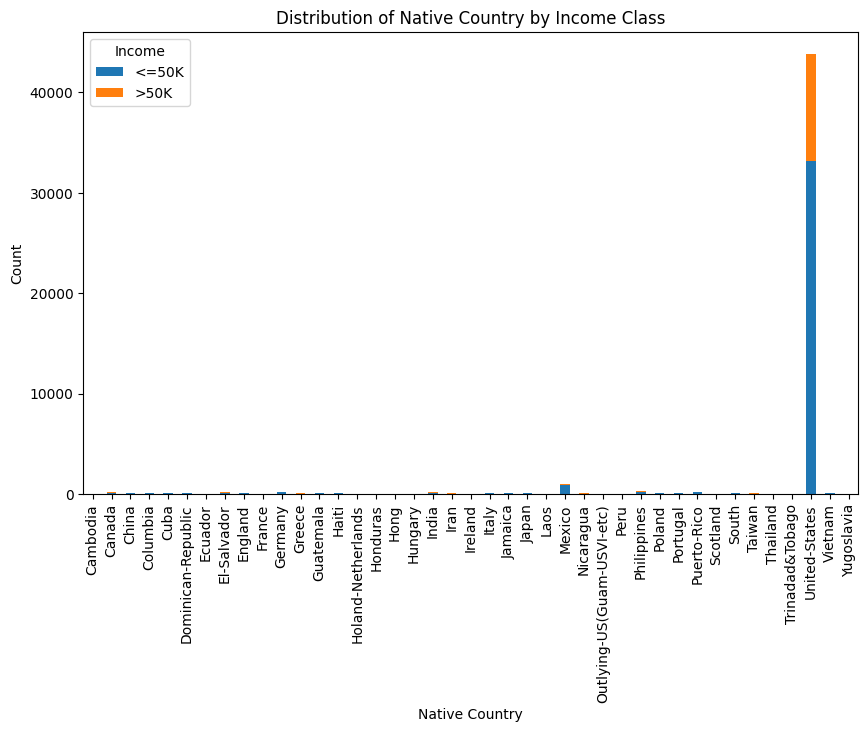

In [57]:
# Plot the cross-tabulation as a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Native Country by Income Class')
plt.xlabel('Native Country')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

Plot Native countries according to the Income classes

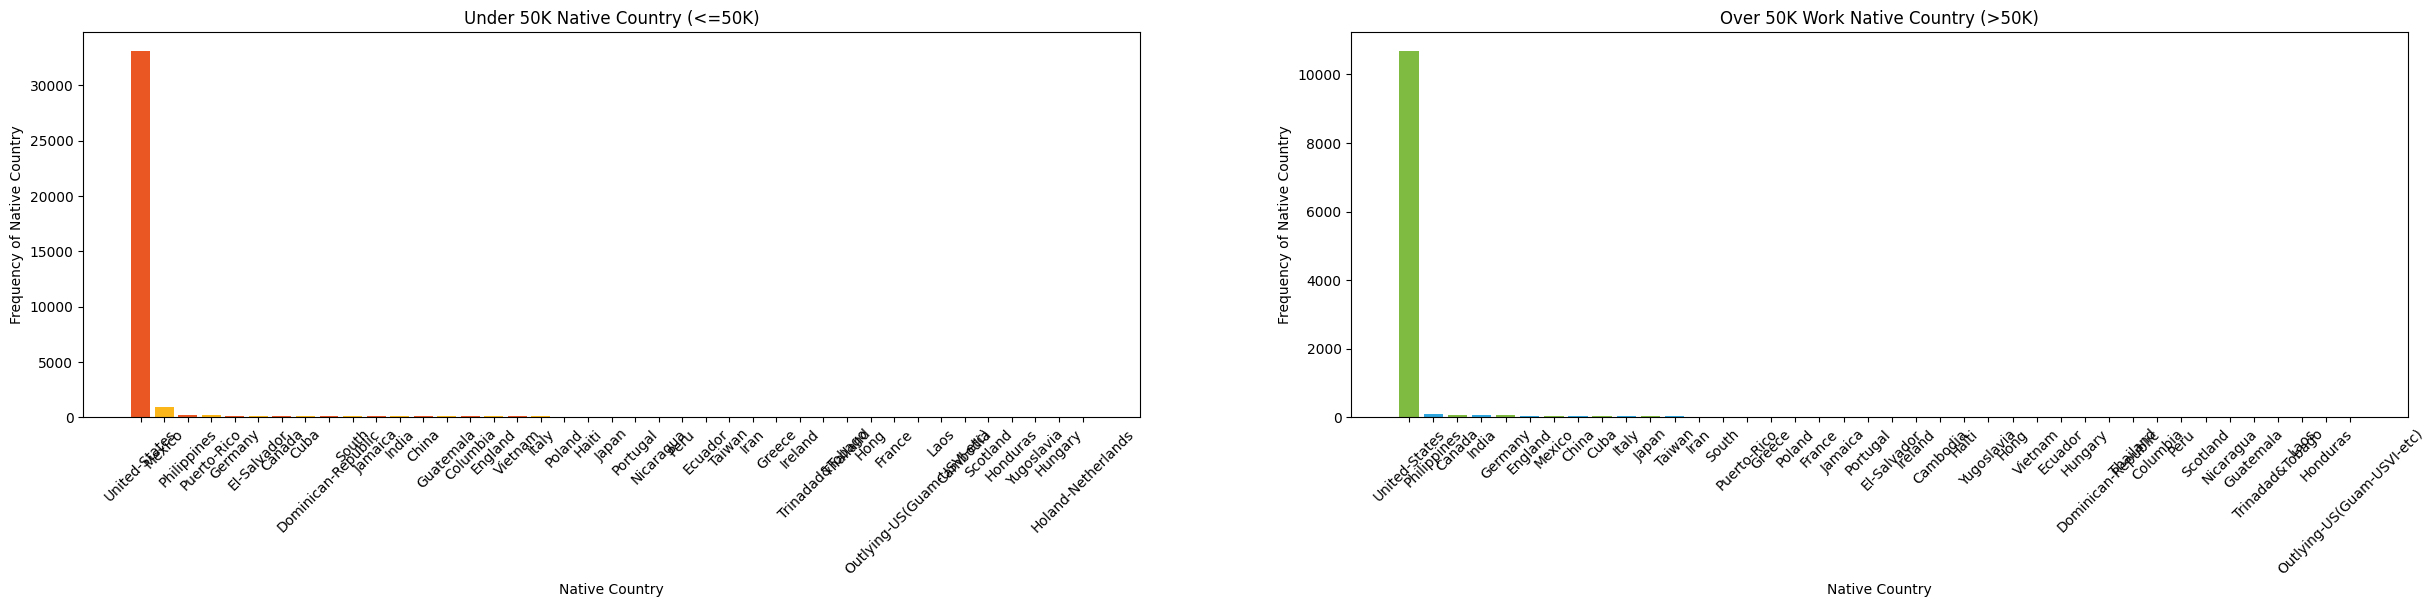

In [58]:
#colors 
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,5))

ax1.bar(under50K_nativeCountry.index,under50K_nativeCountry.values,color=under50K_color)
ax1.set_xlabel("Native Country")
ax1.set_ylabel("Frequency of Native Country")
ax1.set_title("Under 50K Native Country (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability


ax2.bar(over50K_nativeCountry.index,over50K_nativeCountry.values,color=over50K_color)
ax2.set_xlabel("Native Country")
ax2.set_ylabel("Frequency of Native Country")
ax2.set_title("Over 50K Work Native Country (>50K)")
ax2.tick_params(axis='x', rotation=45)

In [59]:
# Calculate the count of "United-States" occurrences
us_count = census_income_df['Native_Country'].value_counts().get('United-States', 0)

# Calculate the total number of entries in the "Native_Country" column
total_entries = len(census_income_df)

# Calculate the percentage
us_percentage = (us_count / total_entries) * 100

print("Percentage of 'United-States' in Native country column:", us_percentage)

Percentage of 'United-States' in Native country column: 89.74243478973015


So I can fill null values of Native Country column with "United-States"

In [60]:
census_income_df['Native_Country'] = census_income_df['Native_Country'].fillna('United-States')

Check if 'Native country' column is ok now.

In [61]:
#check unique values of Work_class column
print(census_income_df['Native_Country'].unique())

['United-States' 'Mexico' 'Philippines' 'Vietnam' 'Germany' 'Portugal'
 'Hong' 'India' 'Cuba' 'Laos' 'Haiti' 'Puerto-Rico' 'Nicaragua' 'Italy'
 'Canada' 'Ireland' 'England' 'Guatemala' 'Jamaica' 'El-Salvador' 'Poland'
 'Iran' 'Taiwan' 'Japan' 'China' 'South' 'Scotland' 'Greece'
 'Trinadad&Tobago' 'Cambodia' 'Columbia' 'Yugoslavia' 'Ecuador' 'Honduras'
 'Dominican-Republic' 'Peru' 'Thailand' 'France' 'Hungary'
 'Outlying-US(Guam-USVI-etc)' 'Holand-Netherlands']


In [62]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  48842 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


All null values are filled

### 3. Remove duplicate rows

Reference - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

In [63]:
# Number of Rows and Cols in DF
census_income_df.shape

(48842, 15)

In [64]:
# Check how many duplicate rows in the DF
duplicate_rows = census_income_df.duplicated().sum()

print("Number of duplicate rows :", duplicate_rows)

Number of duplicate rows : 53


In [65]:
# keep - Drop duplicates except for the first occurrence.
# inplace - Modify the DataFrame directly
census_income_df.drop_duplicates(keep='first', inplace=True)

In [66]:
# Number of Rows and Cols after dropping the duplicate Rows in DF
census_income_df.shape

(48789, 15)

In [67]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48789 non-null  int64 
 1   Work_class      48789 non-null  object
 2   Final_Weight    48789 non-null  int64 
 3   Education       48789 non-null  object
 4   Education_Num   48789 non-null  int64 
 5   Marital_Status  48789 non-null  object
 6   Occupation      48789 non-null  object
 7   Relationship    48789 non-null  object
 8   Race            48789 non-null  object
 9   Sex             48789 non-null  object
 10  Capital_Gain    48789 non-null  int64 
 11  Capital_Loss    48789 non-null  int64 
 12  Hours_per_Week  48789 non-null  int64 
 13  Native_Country  48789 non-null  object
 14  Income          48789 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


### 4.Standardizing Data

Data standardization transforms data into a consistent format across datasets, typically by scaling it to have a mean of zero and a standard deviation of one. This ensures uniformity and facilitates accurate comparison and analysis across variables.

Reference - https://atlan.com/standardize-data/ , 

In [68]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 75 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 73 53 71 76 80 70 68 81 74 90 82 83 85 79 77 78 84 88 86
 89 87]


Work_class
['Private' 'Self-emp-not-inc' 'State-gov' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Never-worked' 'Without-pay']


Final_Weight
[128063 317847  58124 ... 310850 446512  32186]


Education
['HS-grad' 'Masters' 'Assoc-voc' 'Some-college' 'Bachelors' 'Assoc-acdm'
 '5th-6th' '7th-8th' '10th' '9th' '11th' 'Prof-school' 'Doctorate' '12th'
 '1st-4th' 'Preschool']


Education_Num
[ 9 14 11 10 13 12  3  4  6  5  7 15 16  8  2  1]


Marital_Status
['Divorced' 'Married-civ-spouse' 'Never-married' 'Married-spouse-absent'
 'Separated' 'Widowed' 'Married-AF-spouse']


Occupation
['Other-service' 'Exec-managerial' 'Craft-repair' 'Sales' 'Adm-clerical'
 'Transport-moving' 'Prof-specialty' 'Machine-op-inspct' 'Protective-serv'
 'Tech-support' 'Handlers-cleaners'

In [69]:
# Convert all categorical variables to lowercase and remove leading/trailing whitespaces
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country']

for column in categorical_columns:
    census_income_df[column] = census_income_df[column].str.lower().str.strip()

In [70]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 75 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 73 53 71 76 80 70 68 81 74 90 82 83 85 79 77 78 84 88 86
 89 87]


Work_class
['private' 'self-emp-not-inc' 'state-gov' 'federal-gov' 'local-gov'
 'self-emp-inc' 'never-worked' 'without-pay']


Final_Weight
[128063 317847  58124 ... 310850 446512  32186]


Education
['hs-grad' 'masters' 'assoc-voc' 'some-college' 'bachelors' 'assoc-acdm'
 '5th-6th' '7th-8th' '10th' '9th' '11th' 'prof-school' 'doctorate' '12th'
 '1st-4th' 'preschool']


Education_Num
[ 9 14 11 10 13 12  3  4  6  5  7 15 16  8  2  1]


Marital_Status
['divorced' 'married-civ-spouse' 'never-married' 'married-spouse-absent'
 'separated' 'widowed' 'married-af-spouse']


Occupation
['other-service' 'exec-managerial' 'craft-repair' 'sales' 'adm-clerical'
 'transport-moving' 'prof-specialty' 'machine-op-inspct' 'protective-serv'
 'tech-support' 'handlers-cleaners'

### 5.Check correlations with Neumeric values and Income column

<Axes: >

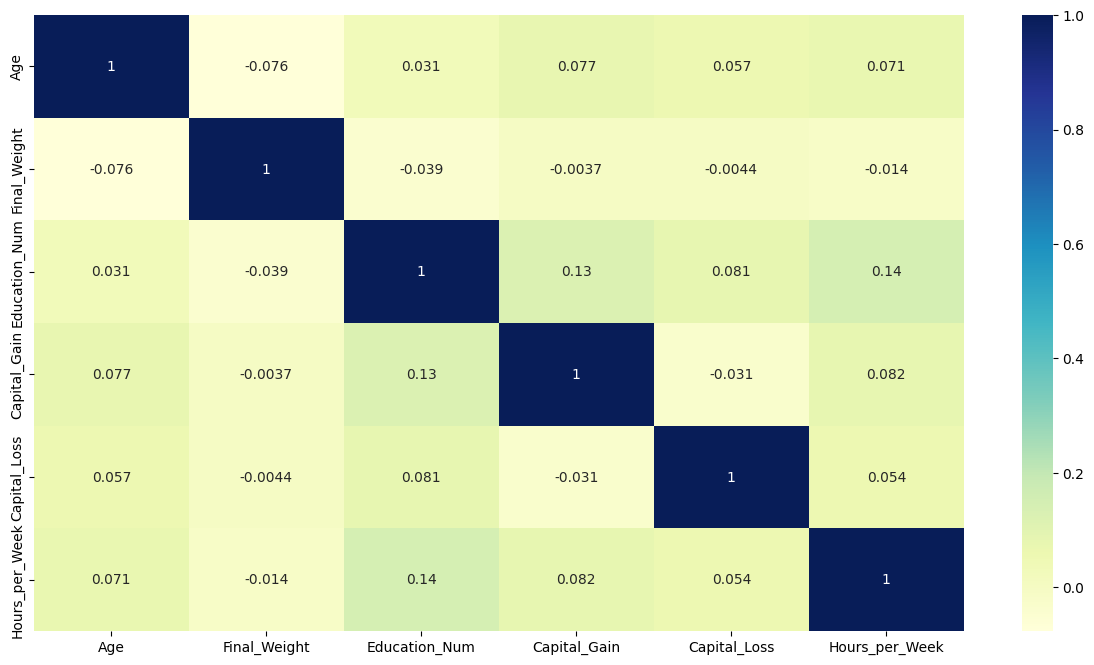

In [71]:
numeric_data = census_income_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="YlGnBu")

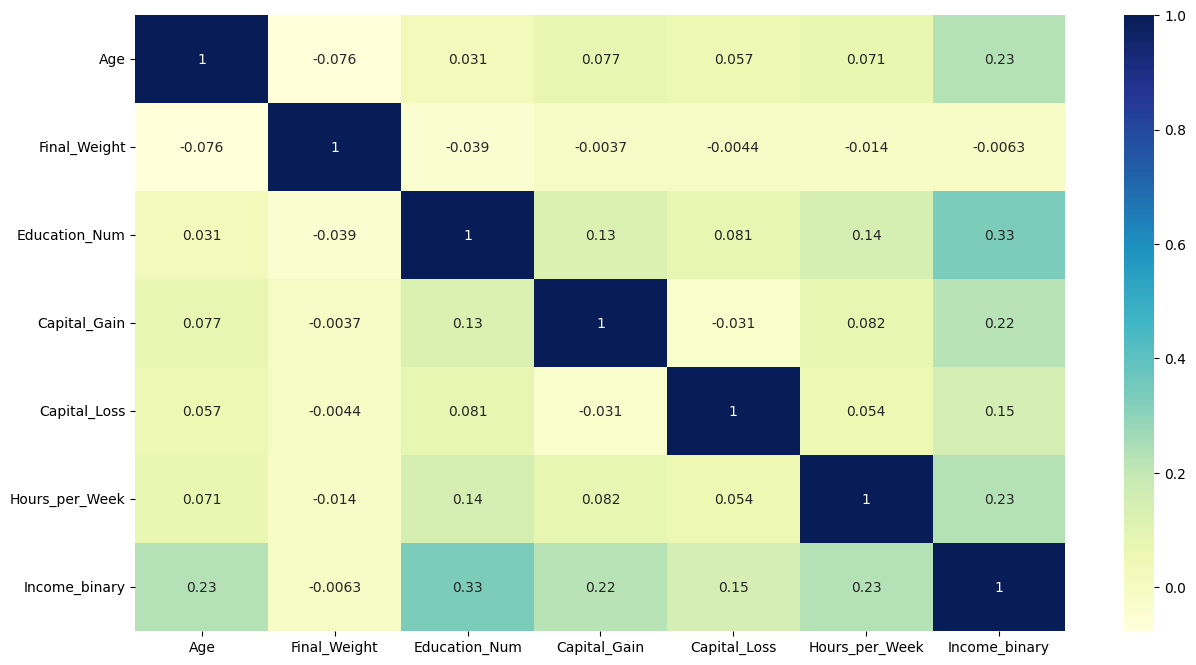

In [72]:
# Convert 'Income' column to binary values
census_income_df['Income_binary'] = np.where(census_income_df['Income'] == '>50K', 1, 0)

# Select numeric columns including the new 'Income_binary' column
numeric_data_with_income = census_income_df.select_dtypes(include=[np.number])

# Plot correlation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(numeric_data_with_income.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [73]:
census_income_df.head(1)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income,Income_binary
0,34,private,128063,hs-grad,9,divorced,other-service,unmarried,white,female,0,0,36,united-states,<=50K,0


In [74]:
# Drop the 'Income_binary' column
census_income_df.drop(columns=['Income_binary'], inplace=True)

In [75]:
census_income_df.head(1)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,34,private,128063,hs-grad,9,divorced,other-service,unmarried,white,female,0,0,36,united-states,<=50K


By considering the correlation heatmap we can see 'Final_Weight' and 'Income' column has -0.0063 correlation. So we can remove 'Final_Weight' from the dataframe

Remove Final_Weight column

In [76]:
# Remove the 'Final_Weight' column from the dataframe
census_income_df.drop(columns=['Final_Weight'], inplace=True)

In [77]:
census_income_df.head(1)

,Age,Work_class,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,34,private,hs-grad,9,divorced,other-service,unmarried,white,female,0,0,36,united-states,<=50K


### 6.Handling Outliers

Outliers are data points that significantly differ from other observations in a dataset. They can arise due to various reasons such as measurement errors, data entry errors, or genuine variability in the data. 

Reference - https://www.linkedin.com/pulse/handling-outliers-ml-best-practices-robust-data-iain-brown-ph-d--mwf6e/, https://towardsdatascience.com/outlier-detection-methods-in-machine-learning-1c8b7cca6cb8

 0   Age             48789 non-null  int64 
 1   Work_class      48789 non-null  object
 2   Final_Weight    48789 non-null  int64 
 3   Education       48789 non-null  object
 4   Education_Num   48789 non-null  int64 
 5   Marital_Status  48789 non-null  object
 6   Occupation      48789 non-null  object
 7   Relationship    48789 non-null  object
 8   Race            48789 non-null  object
 9   Sex             48789 non-null  object
 10  Capital_Gain    48789 non-null  int64 
 11  Capital_Loss    48789 non-null  int64 
 12  Hours_per_Week  48789 non-null  int64 
 13  Native_Country  48789 non-null  object
 14  Income          48789 non-null  object

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Education_Num'}>],
       [<Axes: title={'center': 'Capital_Gain'}>,
        <Axes: title={'center': 'Capital_Loss'}>],
       [<Axes: title={'center': 'Hours_per_Week'}>, <Axes: >]],
      dtype=object)

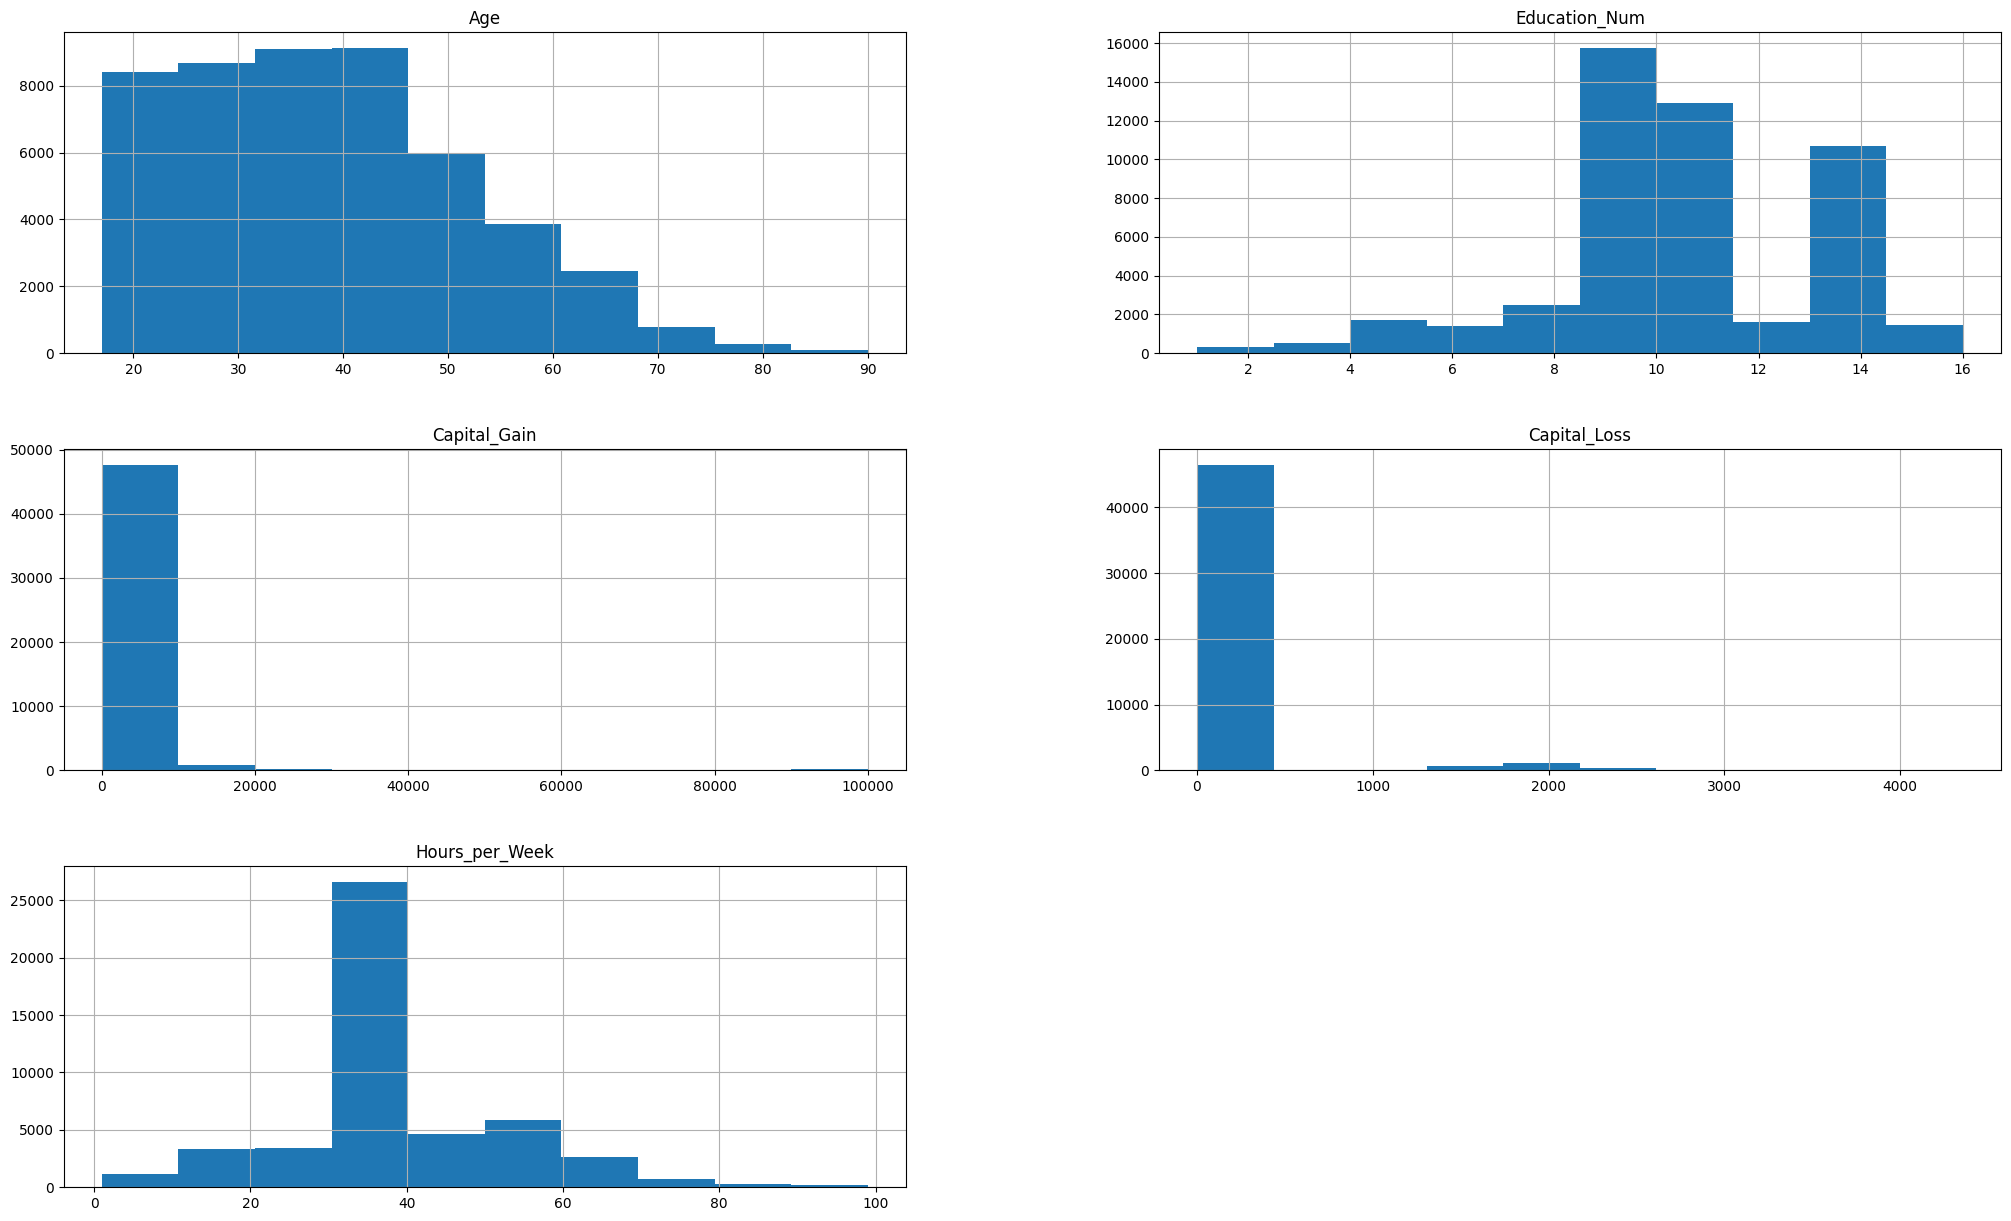

In [78]:
census_income_df.hist(figsize=(25, 15))

### Handle Age column outliers

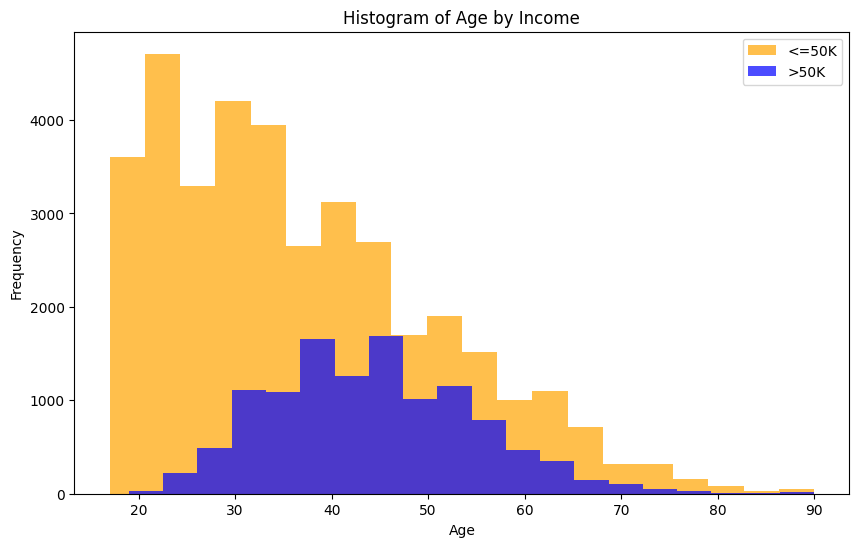

In [79]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Age column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Age'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Age'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Age by Income')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [80]:
census_income_df['Age'].describe()

count    48789.000000
mean        38.652647
std         13.708593
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: Age, dtype: float64

In the Age column, for both >50k income and <=50k has Right-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


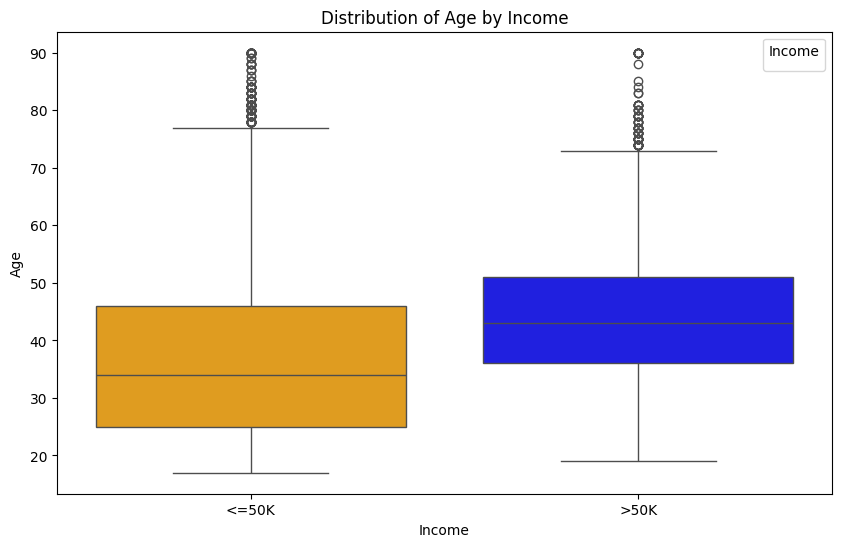

In [81]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of age column which Income >50K

In [82]:
# Select age data for income >50k
age_over50K = census_income_df[census_income_df['Income'] == '>50K']['Age']

# calculate IQR
Q1 = age_over50K.quantile(0.25)
Q3 = age_over50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower limit:", lower_bound)
print("Upper limit:", upper_bound)

Lower limit: 13.5
Upper limit: 73.5


In [83]:
# get count of rows where income is >50K and age is greater than upper bound
outliers_over50K_age = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Age'] > upper_bound)]

print("Number of rows with income >50K and age > upper bound:", len(outliers_over50K_age))

Number of rows with income >50K and age > upper bound: 90


Informations about that rows

In [84]:
outliers_over50K_age['Age'].describe()

count    90.000000
mean     79.022222
std       5.348480
min      74.000000
25%      75.000000
50%      77.000000
75%      81.000000
max      90.000000
Name: Age, dtype: float64

By analyzing data I considerd adjusting the outliers instead of removing them.So set any age value above the upper bound to the whole number of the upper bound value (73) 

In [85]:
# Cap outliers at the upper bound value (rounded down to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Age'] > upper_bound), 'Age'] = int(upper_bound)

In [86]:
print("Age column unique values")
print(census_income_df['Age'].unique())

Age column unique values
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 73 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 53 71 76 80 70 68 81 74 75 90 82 83 85 79 77 78 84 88 86
 89 87]


After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


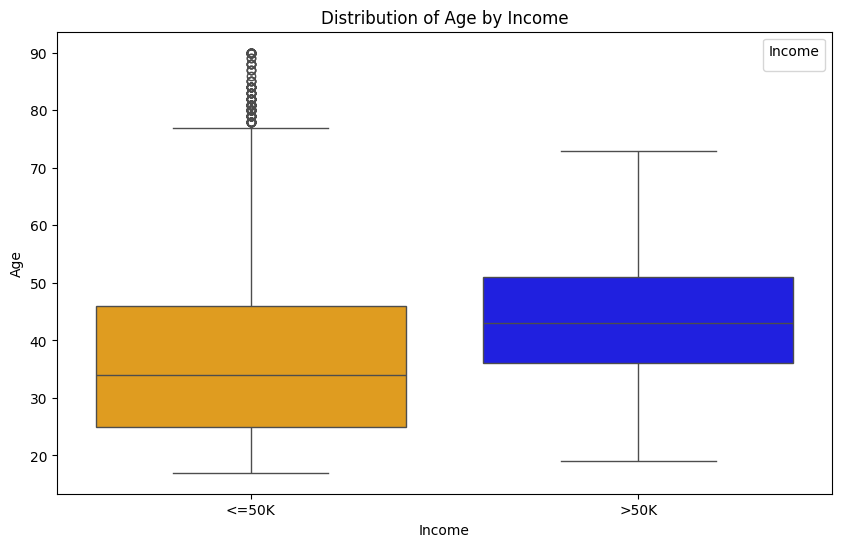

In [87]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of age column which Income <=50K

In [88]:
# Select age data for income <= 50k
age_under50K = census_income_df[census_income_df['Income'] == '<=50K']['Age']

# Calculate IQR
Q1 = age_under50K.quantile(0.25)
Q3 = age_under50K.quantile(0.75)
IQR = Q3 - Q1

# upper bounds
upper_bound = Q3 + 1.5 * IQR

print("Upper limit:", upper_bound)

Upper limit: 77.5


In [89]:
# get count of rows where income is <=50K and age is greater than upper bound
outliers_under50K_age = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Age'] > upper_bound)]

print("Number of rows with income <=50K and age > upper bound:", len(outliers_under50K_age))

Number of rows with income <=50K and age > upper bound: 206


Informations about that rows

In [90]:
outliers_under50K_age['Age'].describe()

count    206.000000
mean      82.771845
std        4.295361
min       78.000000
25%       80.000000
50%       81.000000
75%       85.750000
max       90.000000
Name: Age, dtype: float64

By analyzing data, I considerd adjusting the outliers instead of removing them.So set any age value above the upper bound to the whole number of the upper bound value (77) 

In [91]:
# Cap outliers at the upper bound value for income <=50K and age > upper bound
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Age'] > upper_bound), 'Age'] = int(upper_bound)

In [92]:
print("Age column unique values")
print(census_income_df['Age'].unique())

Age column unique values
[34 57 41 52 33 39 28 44 32 26 58 40 65 22 23 20 35 30 37 27 62 72 50 36
 49 45 63 59 46 54 38 29 47 73 19 31 43 48 24 21 42 55 17 18 25 61 67 66
 56 60 64 51 69 53 71 76 77 70 68 74 75]


After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


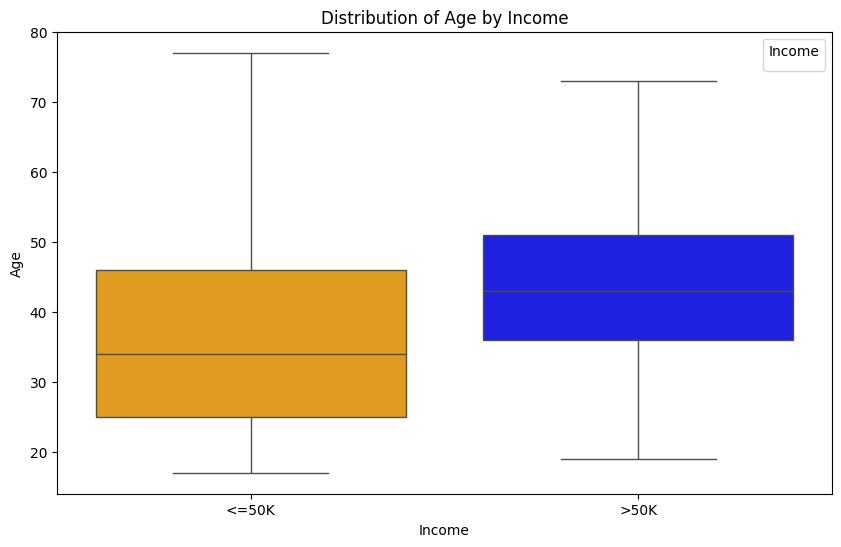

In [93]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Education_Num column outliers

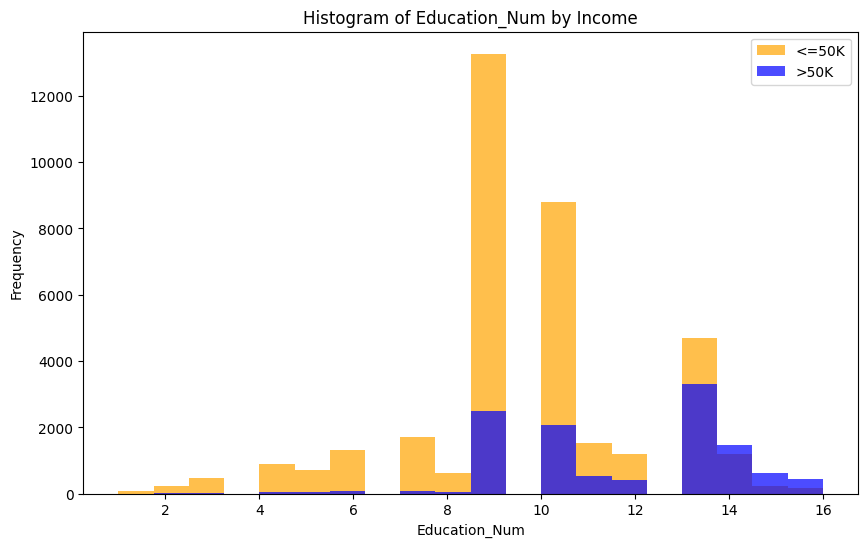

In [94]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Education_Num column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Education_Num'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Education_Num'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Education_Num by Income')
plt.xlabel('Education_Num')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In the Education_Num column, for both >50k income and <=50k has Left-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


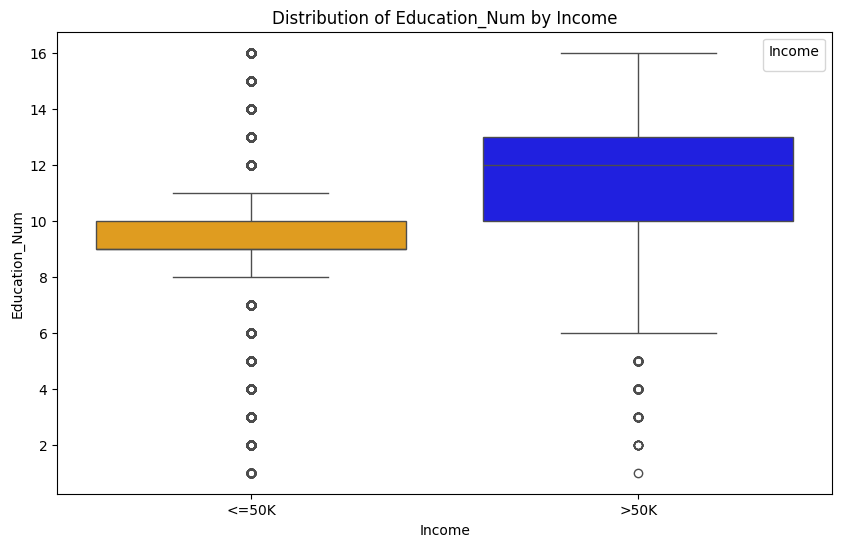

In [95]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Education_Num column which Income >50K

In [96]:
# Select Education_Num data for income >50k
education_num_over50K = census_income_df[census_income_df['Income'] == '>50K']['Education_Num']

# calculate IQR
Q1 = education_num_over50K.quantile(0.25)
Q3 = education_num_over50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR

print("Lower limit:", lower_bound)

Lower limit: 5.5


In [97]:
# get count of rows where income is >50K and Education_Num is less than the lower bound
outliers_over50K_education_num = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Education_Num'] < lower_bound)]

print("Number of rows with income >50K and Education_Num < lower bound:", len(outliers_over50K_education_num))

Number of rows with income >50K and Education_Num < lower bound: 139


When handeling outliers of income >50K and Education_Num < lower bound we want to round the lower bound value up to the nearest whole number 

In [98]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Education_Num'] < lower_bound), 'Education_Num'] = math.ceil(lower_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


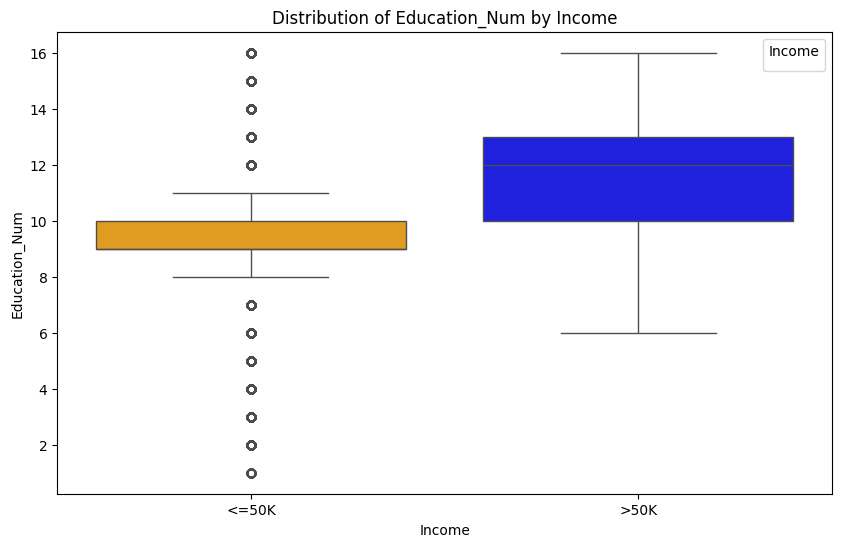

In [99]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Education_Num column which Income <=50K

In [100]:
# Select Education_Num data for income <=50k
education_num_under50K = census_income_df[census_income_df['Income'] == '<=50K']['Education_Num']

# calculate IQR
Q1 = education_num_under50K.quantile(0.25)
Q3 = education_num_under50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

Lower bound: 7.5
Upper bound: 11.5


In [101]:
# get count of rows where income is <=50K and Education_Num is less than the lower bound
outliers_under50K_education_num_lower = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] < lower_bound)]

# get count of rows where income is <=50K and Education_Num is greater than the upper bound
outliers_under50K_education_num_upper = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] > upper_bound)]

print("Number of rows with income <=50K and Education_Num < lower bound:", len(outliers_under50K_education_num_lower))
print("Number of rows with income <=50K and Education_Num > upper bound:", len(outliers_under50K_education_num_upper))

Number of rows with income <=50K and Education_Num < lower bound: 5426
Number of rows with income <=50K and Education_Num > upper bound: 7467


In [102]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] < lower_bound), 'Education_Num'] = math.ceil(lower_bound)

# Cap outliers at the upper bound value for income <=50K and Education_Num > upper bound
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] > upper_bound), 'Education_Num'] = int(upper_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


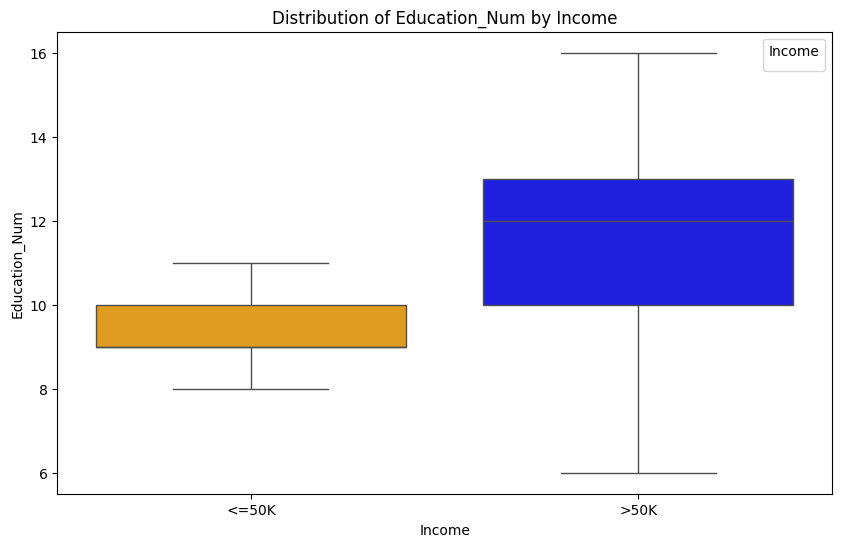

In [103]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Capital_Gain column outliers

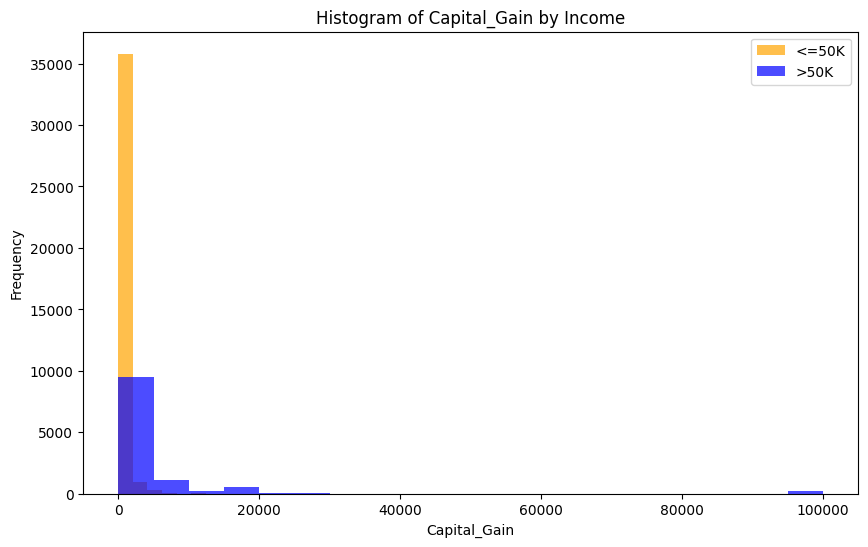

In [104]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Capital_Gain'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Capital_Gain'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Capital_Gain by Income')
plt.xlabel('Capital_Gain')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In the Capital_Gain column, for both >50k income and <=50k has Right-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


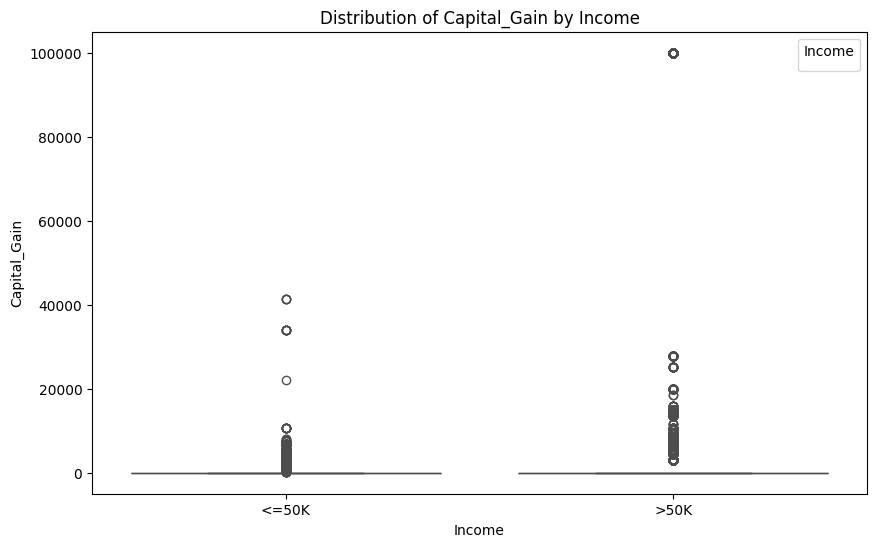

In [105]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Capital_Gain" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Capital_Gain"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Capital_Gain by Income")
plt.ylabel("Capital_Gain")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

This boxplot doesn't provide meaningful insights due to the wide range of values and potential outliers

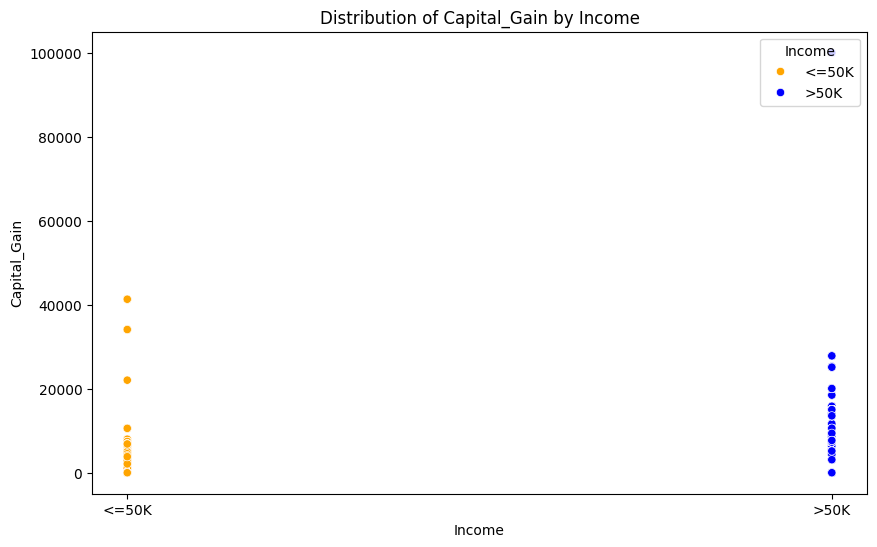

In [106]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create scatter plots for the "Capital_Gain" column with hue for income group
plt.figure(figsize=(10, 6))
sns.scatterplot(data=census_income_df, x="Income", y="Capital_Gain", hue="Income", palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Capital_Gain by Income")
plt.xlabel("Income")
plt.ylabel("Capital_Gain")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Capital_Loss column outliers

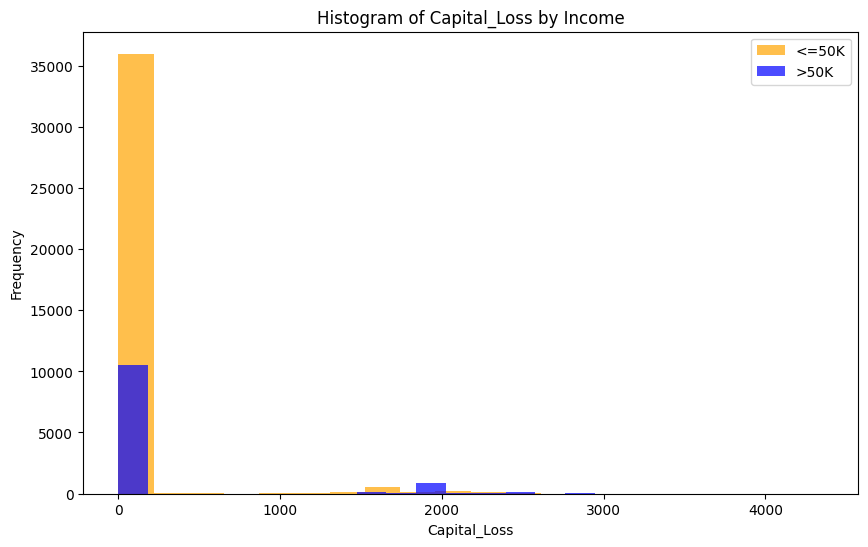

In [107]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Capital_Loss'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Capital_Loss'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Capital_Loss by Income')
plt.xlabel('Capital_Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


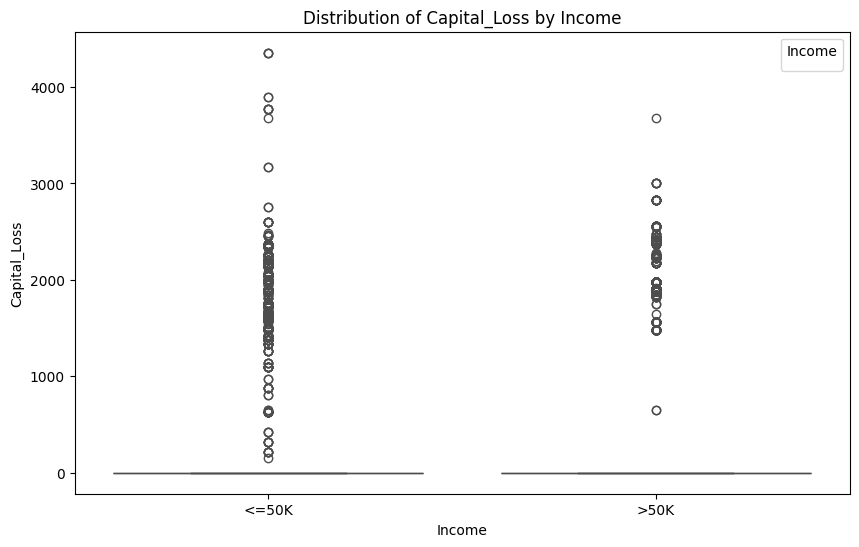

In [108]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Capital_Loss" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Capital_Loss"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Capital_Loss by Income")
plt.ylabel("Capital_Loss")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Hours_per_Week column outliers

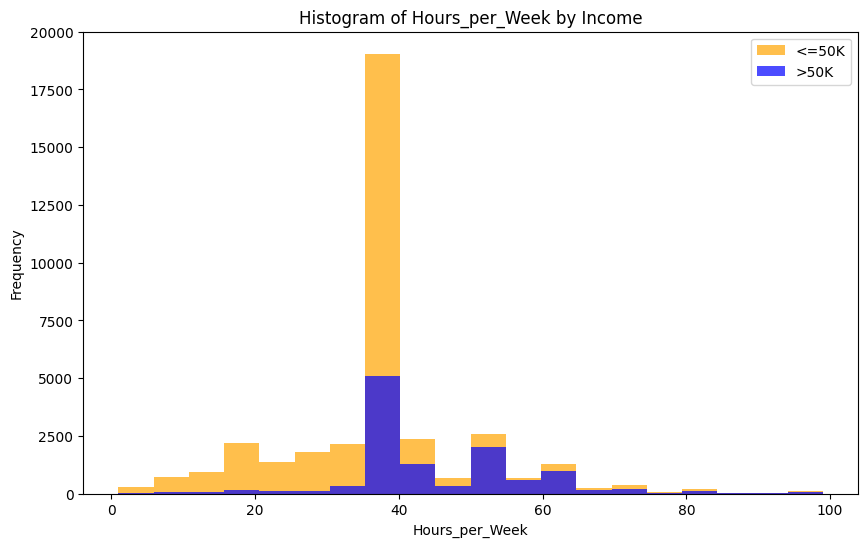

In [109]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Hours_per_Week'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Hours_per_Week'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Hours_per_Week by Income')
plt.xlabel('Hours_per_Week')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


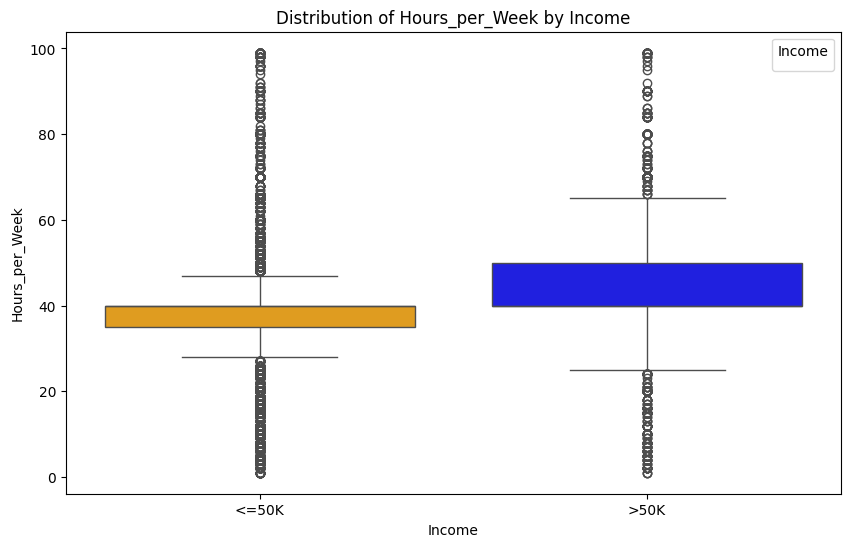

In [110]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Hours_per_Week" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Hours_per_Week"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Hours_per_Week by Income")
plt.ylabel("Hours_per_Week")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Hours_per_Week column which Income >50K

In [111]:
# Select Hours_per_Week data for income >50k
hours_over50K = census_income_df[census_income_df['Income'] == '>50K']['Hours_per_Week']

# Calculate IQR
Q1 = hours_over50K.quantile(0.25)
Q3 = hours_over50K.quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower limit:", lower_bound)
print("Upper limit:", upper_bound)

Lower limit: 25.0
Upper limit: 65.0


In [112]:
# Filter the DataFrame for rows where income is >50K and Hours_per_Week is less than the lower bound
outliers_upper50K_hours_per_week_lower = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Hours_per_Week'] < lower_bound)]

# Filter the DataFrame for rows where income is >50K and Hours_per_Week is greater than the upper bound
outliers_upper50K_hours_per_week_upper = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Hours_per_Week'] > upper_bound)]

print("Number of rows with income >50K and Hours_per_Week < lower bound:", len(outliers_upper50K_hours_per_week_lower))
print("Number of rows with income >50K and Hours_per_Week > upper bound:", len(outliers_upper50K_hours_per_week_upper))

Number of rows with income >50K and Hours_per_Week < lower bound: 345
Number of rows with income >50K and Hours_per_Week > upper bound: 436


In [113]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Hours_per_Week'] < lower_bound), 'Hours_per_Week'] = math.ceil(lower_bound)

# Cap outliers at the upper bound value for income >50K and Hours_per_Week > upper bound
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Hours_per_Week'] > upper_bound), 'Hours_per_Week'] = int(upper_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


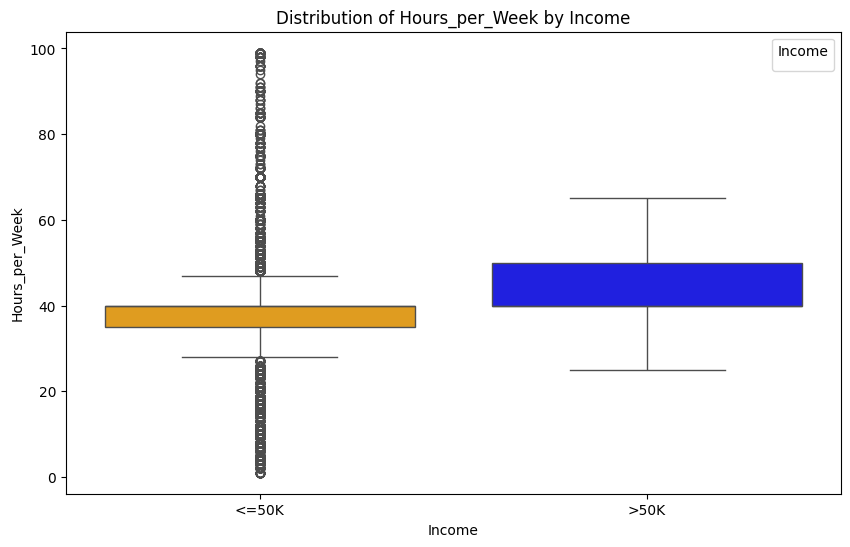

In [114]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Hours_per_Week" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Hours_per_Week"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Hours_per_Week by Income")
plt.ylabel("Hours_per_Week")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Hours_per_Week column which Income <=50K

In [115]:
# Select Hours_per_Week data for income <= 50k
hours_under50K = census_income_df[census_income_df['Income'] == '<=50K']['Hours_per_Week']

# Calculate IQR
Q1 = hours_under50K.quantile(0.25)
Q3 = hours_under50K.quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower limit:", lower_bound)
print("Upper limit:", upper_bound)

Lower limit: 27.5
Upper limit: 47.5


In [116]:
# Filter the DataFrame for rows where income is <= 50K and Hours_per_Week is less than the lower bound
outliers_under50K_hours_per_week_lower = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Hours_per_Week'] < lower_bound)]

# Filter the DataFrame for rows where income is <= 50K and Hours_per_Week is greater than the upper bound
outliers_under50K_hours_per_week_lower = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Hours_per_Week'] > upper_bound)]

# Print the number of rows that meet the criteria
print("Number of rows with income <=50K and Hours_per_Week < lower bound:", len(outliers_under50K_hours_per_week_lower))
print("Number of rows with income <=50K and Hours_per_Week > upper bound:", len(outliers_under50K_hours_per_week_lower))


Number of rows with income <=50K and Hours_per_Week < lower bound: 6104
Number of rows with income <=50K and Hours_per_Week > upper bound: 6104


In [117]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Hours_per_Week'] < lower_bound), 'Hours_per_Week'] = math.ceil(lower_bound)

# Cap outliers at the upper bound value for income <=50K and Hours_per_Week > upper bound
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Hours_per_Week'] > upper_bound), 'Hours_per_Week'] = int(upper_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


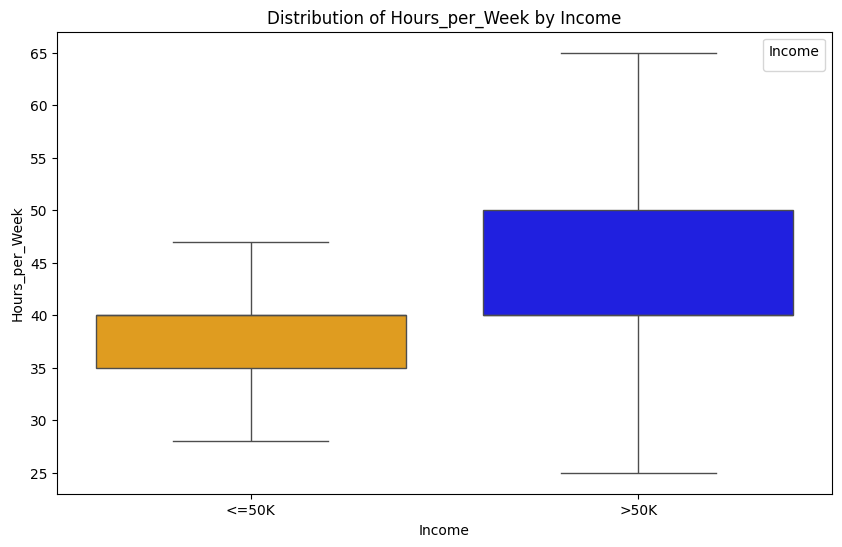

In [118]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Hours_per_Week" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Hours_per_Week"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Hours_per_Week by Income")
plt.ylabel("Hours_per_Week")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

In [119]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48789 non-null  int64 
 1   Work_class      48789 non-null  object
 2   Education       48789 non-null  object
 3   Education_Num   48789 non-null  int64 
 4   Marital_Status  48789 non-null  object
 5   Occupation      48789 non-null  object
 6   Relationship    48789 non-null  object
 7   Race            48789 non-null  object
 8   Sex             48789 non-null  object
 9   Capital_Gain    48789 non-null  int64 
 10  Capital_Loss    48789 non-null  int64 
 11  Hours_per_Week  48789 non-null  int64 
 12  Native_Country  48789 non-null  object
 13  Income          48789 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.6+ MB


### 7.Data Type Conversion

In [120]:
# Convert categorical columns to categorical data type
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country', 'Income']
for col in categorical_columns:
    census_income_df[col] = census_income_df[col].astype('category')

In [121]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             48789 non-null  int64   
 1   Work_class      48789 non-null  category
 2   Education       48789 non-null  category
 3   Education_Num   48789 non-null  int64   
 4   Marital_Status  48789 non-null  category
 5   Occupation      48789 non-null  category
 6   Relationship    48789 non-null  category
 7   Race            48789 non-null  category
 8   Sex             48789 non-null  category
 9   Capital_Gain    48789 non-null  int64   
 10  Capital_Loss    48789 non-null  int64   
 11  Hours_per_Week  48789 non-null  int64   
 12  Native_Country  48789 non-null  category
 13  Income          48789 non-null  category
dtypes: category(9), int64(5)
memory usage: 2.7 MB


### 8.Encoding Categorical Columns

Use LabelEncoder for encoding categorical labels into numerical labels

In [126]:
from sklearn.preprocessing import LabelEncoder

# Define the categorical columns
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country', 'Income']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and encode its values
for col in categorical_columns:
    census_income_df[col] = label_encoder.fit_transform(census_income_df[col])

Label encoders for each categorical columns

In [123]:
# Define the categorical columns
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country', 'Income']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and encode its values
for col in categorical_columns:
    census_income_df[col] = label_encoder.fit_transform(census_income_df[col])
    print(f"Encoded labels for column '{col}': {label_encoder.classes_}")

Encoded labels for column 'Work_class': [0 1 2 3 4 5 6 7]
Encoded labels for column 'Education': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Encoded labels for column 'Marital_Status': [0 1 2 3 4 5 6]
Encoded labels for column 'Occupation': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Encoded labels for column 'Relationship': [0 1 2 3 4 5]
Encoded labels for column 'Race': [0 1 2 3 4]
Encoded labels for column 'Sex': [0 1]
Encoded labels for column 'Native_Country': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Encoded labels for column 'Income': [0 1]


In [125]:
# Define the categorical columns
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country', 'Income']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and encode its values
for col in categorical_columns:
    census_income_df[col] = label_encoder.fit_transform(census_income_df[col])
    if col == 'Income':
        print(f"index 0 represents the '{label_encoder.inverse_transform([0])[0]}' class, and the label with index 1 represents the '{label_encoder.inverse_transform([1])[0]}' class")


index 0 represents the '0' class, and the label with index 1 represents the '1' class


In [121]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             48789 non-null  int64
 1   Work_class      48789 non-null  int32
 2   Education       48789 non-null  int32
 3   Education_Num   48789 non-null  int64
 4   Marital_Status  48789 non-null  int32
 5   Occupation      48789 non-null  int32
 6   Relationship    48789 non-null  int32
 7   Race            48789 non-null  int32
 8   Sex             48789 non-null  int32
 9   Capital_Gain    48789 non-null  int64
 10  Capital_Loss    48789 non-null  int64
 11  Hours_per_Week  48789 non-null  int64
 12  Native_Country  48789 non-null  int32
 13  Income          48789 non-null  int32
dtypes: int32(9), int64(5)
memory usage: 3.9 MB


In [130]:
# Check the encoded labels for the 'Income' column
income_labels = label_encoder.classes_
print(income_labels)

[0 1]


In [122]:
census_income_df.head(1)

,Age,Work_class,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,33,3,8,11,4,0,3,4,0,0,0,40,38,0


### 9.Check Correlation 

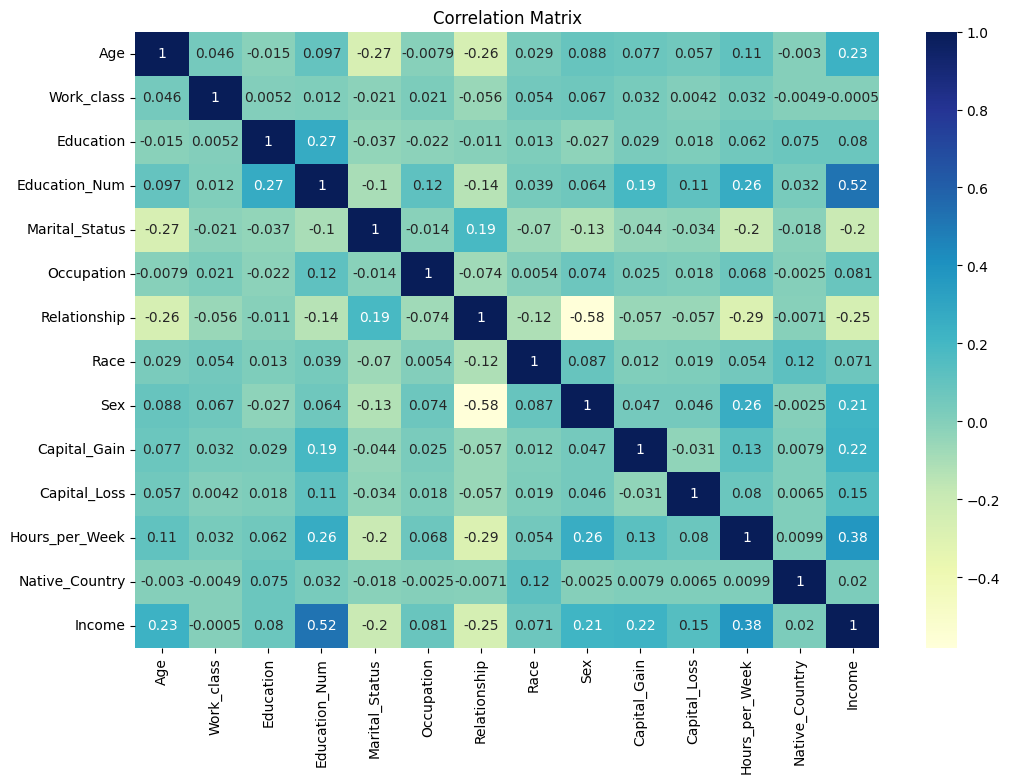

In [123]:
# Calculate the correlation matrix
correlation_matrix = census_income_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

In [124]:
# Calculate the correlation matrix
correlation_matrix = census_income_df.corr()

# Extract correlation with the target variable
correlation_with_income = correlation_matrix['Income'].sort_values(ascending=False)

print(correlation_with_income)

Income            1.000000
Education_Num     0.521535
Hours_per_Week    0.375397
Age               0.231522
Capital_Gain      0.223060
Sex               0.214703
Capital_Loss      0.147554
Occupation        0.080864
Education         0.080114
Race              0.070958
Native_Country    0.020152
Work_class       -0.000504
Marital_Status   -0.198846
Relationship     -0.253277
Name: Income, dtype: float64


Education_Num: This feature has a relatively high positive correlation with income and represents the level of education, which is often a strong predictor of income.

Hours_per_Week: This feature also has a positive correlation with income, indicating that individuals who work longer hours tend to have higher incomes.

Age: Age is positively correlated with income, suggesting that older individuals may have higher incomes on average.

Capital_Gain: Although its correlation is not as high as the others, capital gain still provides valuable information about an individual's financial situation and can be a predictor of income.

Sex: While not highly correlated, it still shows some correlation and may capture gender-based income disparities.

Capital_Loss: Similar to capital gain, capital loss provides information about an individual's financial activities and can contribute to predicting income.

Occupation: While its correlation is not very high, occupation can still be a relevant predictor of income, capturing differences in income across different professions.

Marital_Status: This feature has a moderate negative correlation with income, suggesting that marital status may influence income levels.

Relationship: Similarly, relationship status has a moderate negative correlation with income, indicating that individuals in certain types of relationships may have different income levels.

Remove irrelevant features

In [125]:
# List of columns to remove
columns_to_remove = ['Work_class', 'Education', 'Race', 'Native_Country']

# Drop the columns from the DataFrame
census_income_df.drop(columns=columns_to_remove, inplace=True)

In [126]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             48789 non-null  int64
 1   Education_Num   48789 non-null  int64
 2   Marital_Status  48789 non-null  int32
 3   Occupation      48789 non-null  int32
 4   Relationship    48789 non-null  int32
 5   Sex             48789 non-null  int32
 6   Capital_Gain    48789 non-null  int64
 7   Capital_Loss    48789 non-null  int64
 8   Hours_per_Week  48789 non-null  int64
 9   Income          48789 non-null  int32
dtypes: int32(5), int64(5)
memory usage: 3.2 MB


In [127]:
#  save the dataset
file_path = "census_income_processed.csv"

# Save the DataFrame to a CSV file
census_income_df.to_csv(file_path, index=False)

print("Dataset saved successfully.")

Dataset saved successfully.


In [128]:
census_income_df.head()

,Age,Education_Num,Marital_Status,Occupation,Relationship,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Income
0,33,11,4,0,3,0,0,0,40,0
1,30,11,4,3,2,0,0,0,45,0
2,52,9,2,13,0,1,0,0,40,1
3,37,9,2,13,0,1,0,0,47,0
4,76,8,6,0,4,0,0,0,40,0


### 10.Feature Scaling

Standardize the range of independent variables or features of a dataset. It ensures that all features have a similar scale, which is particularly important for algorithms that use distance-based calculations or gradient descent optimization.

Use Standardization (Z-score normalization) for feature scaling

In [129]:
scaler = StandardScaler()

# features to scale
columns_to_scale = ['Age', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_Week']

# Apply Standardization to the specified columns
census_income_df[columns_to_scale] = scaler.fit_transform(census_income_df[columns_to_scale])

In [130]:
census_income_df.head()

,Age,Education_Num,Marital_Status,Occupation,Relationship,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Income
0,-0.413037,0.558575,4,0,3,0,-0.144884,-0.217251,-0.044286,0
1,-0.633631,0.558575,4,3,2,0,-0.144884,-0.217251,0.632276,0
2,0.984056,-0.623558,2,13,0,1,-0.144884,-0.217251,-0.044286,1
3,-0.118912,-0.623558,2,13,0,1,-0.144884,-0.217251,0.902901,0
4,2.748805,-1.214625,6,0,4,0,-0.144884,-0.217251,-0.044286,0


### 11.Addressing Data Imbalance

Class Imbalance - distribution of classes in the dataset is not equal or nearly equal

References - https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/, https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

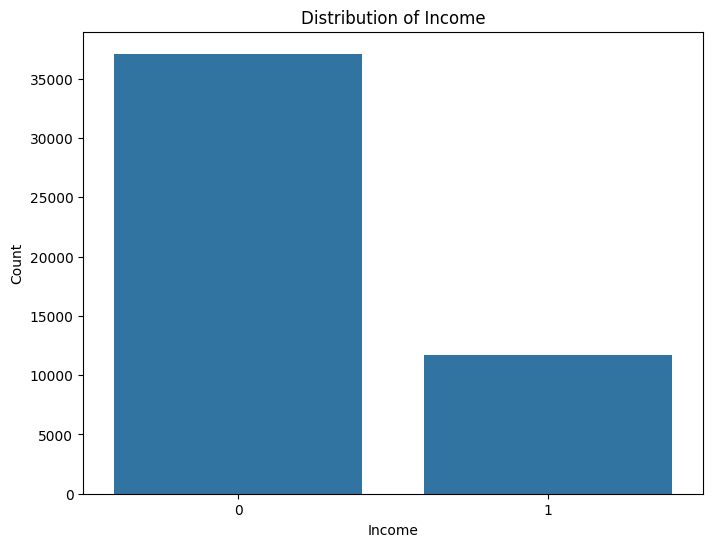

In [131]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Income', data=census_income_df)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

In [132]:
income_counts = census_income_df['Income'].value_counts()
print(income_counts)

Income
0    37109
1    11680
Name: count, dtype: int64


There is indeed an imbalance in the target variable 'Income', with significantly more samples belonging to class 0 compared to class 1. 
So decided to use Oversampling(Increase the number of minority class samples by randomly duplicating them or generating synthetic samples). Use SMOTE for oversampling.

In [133]:
# Separate features and target variable
X = census_income_df.drop(columns=['Income'])
y = census_income_df['Income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### 12. Train the model

### Naïve Bayes Classification

In [134]:
nb_classifier = GaussianNB()

# Train the classifier on the resampled training data
nb_classifier.fit(X_train_resampled, y_train_resampled)

# prediction 
y_pred_nb = nb_classifier.predict(X_test)

### Random Forest Classification

In [135]:
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# prediction
y_pred_rf = rf_classifier.predict(X_test)

### Evaluate

Accuracy = (Number of correct predictions) / (Overall number of predictions)

Reference - https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/  ,  https://www.edlitera.com/en/blog/posts/evaluating-classification-models

In [136]:
# Calculate test data accuracy for Naive Bayes
test_accuracy_nb = accuracy_score(y_test, y_pred_nb) * 100
print("Test data accuracy for Naive Bayes:", test_accuracy_nb)

# Calculate train data accuracy for Naive Bayes
train_accuracy_nb = accuracy_score(y_train_resampled, nb_classifier.predict(X_train_resampled)) * 100
print("Train data accuracy for Naive Bayes:", train_accuracy_nb)

The accuracy of the Naive Bayes model is 88.20%


In [137]:
# Calculate test data accuracy for Random Forest Classifier
test_accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
print("Test data accuracy for Random Forest Classifier:", test_accuracy_rf)

# Calculate train data accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train_resampled, rf_classifier.predict(X_train_resampled)) * 100
print("Train data accuracy for Random Forest Classifier:", train_accuracy_rf)

The accuracy of the Random Forest Classifier is 93.16%


Both Naive Bayes and Random Forest Classifier models give good performance after applying SMOTE. So didn't experiment with PCA.

### Evaluate using different evaluation metrics

In [141]:
#Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print("Naïve Bayes Classifier Metrics:")
print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1 Score:", f1_nb)
print("Confusion Matrix for Naïve Bayes Classifier:")
print(confusion_matrix_nb)

Naïve Bayes Classifier Metrics:
Accuracy: 0.8820455011272802
Precision: 0.805993690851735
Recall: 0.6622030237580994
F1 Score: 0.7270571496324402
ROC AUC Score: 0.8063131201015405
Confusion Matrix for Naïve Bayes Classifier:
[[7074  369]
 [ 782 1533]]


In [143]:
# Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRandom Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix_rf)


Random Forest Classifier Metrics:
Accuracy: 0.9316458290633326
Precision: 0.8539518900343642
Recall: 0.8587473002159827
F1 Score: 0.8563428817574844
ROC AUC Score: 0.9065333975216686
Confusion Matrix for Random Forest Classifier:
[[7103  340]
 [ 327 1988]]


### Table to compare the evaluation metrics of Naive Bayes and Random Forest Classifier

In [144]:
# Define the evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Naive Bayes metrics
nb_metrics = [accuracy_nb, precision_nb, recall_nb, f1_nb]

# Random Forest Classifier metrics
rf_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({
    'Metrics': metrics,
    'Naive Bayes': nb_metrics,
    'Random Forest Classifier': rf_metrics
})

print(df_metrics)

     Metrics  Naive Bayes  Random Forest Classifier
0   Accuracy     0.882046                  0.931646
1  Precision     0.805994                  0.853952
2     Recall     0.662203                  0.858747
3   F1 Score     0.727057                  0.856343
4    ROC AUC     0.806313                  0.906533


### Confusion Matrix

In [ ]:
# Create confusion matrices
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naïve Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### Save models

In [146]:
#from joblib import dump

# Save Naïve Bayes model
#dump(nb_classifier, 'naive_bayes_model.pkl')

# Save Random Forest model
#dump(rf_classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Load saved models

In [147]:
#from joblib import load

# Load Naïve Bayes model
#naive_bayes_model = load('naive_bayes_model.pkl')

# Load Random Forest model
#random_forest_model = load('random_forest_model.pkl')